In [1]:
# Common imports for both tasks
import pandas as pd
import requests
from pymongo import MongoClient
from psycopg2 import extras
import psycopg2
import xml.etree.ElementTree as ET
from itertools import islice
from concurrent.futures import ThreadPoolExecutor
import luigi

# MongoDB and PostgreSQL connection parameters
mongo_uri = "mongodb://localhost:27017/"
pg_params = {
"host": "localhost",
"database": "postgres",
"user": "postgres",
"password": "Thanksgiving2024"
}


Pushing XML  Data to MongoDb

In [2]:
import requests
from pymongo import MongoClient
import xml.etree.ElementTree as ET
from io import BytesIO

mongo_uri = "mongodb://localhost:27017/"

# Function to fetch XML data from the URL
def fetch_xml_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        return BytesIO(response.content)
    else:
        print("Failed to fetch XML data")
        return None


def insert_xml_to_mongodb(records, collection_name):
    client = MongoClient(mongo_uri)
    db = client.DatabaseAnalytics
    collection = db[collection_name]

    collection.insert_many(records)
    print(f"{len(records)} records inserted into MongoDB.")
    client.close()

# Process XML data and store in MongoDB
def process_and_store_data(xml_data, collection_name, limit):
    records = []
    root = ET.iterparse(xml_data)
    for event, elem in root:
        if elem.tag == 'row':
            record = {}
            for child in elem:
                record[child.tag] = child.text
            records.append(record)
            if len(records) >= limit:
                break

    insert_xml_to_mongodb(records, collection_name)

# Main function to execute the process
def main():
    xml_url = "https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.xml?accessType=DOWNLOAD"
    collection_name = "MotorVehicleCollisions"
    limit = 1500
    xml_data = fetch_xml_data(xml_url)
    if xml_data:
        process_and_store_data(xml_data, collection_name, limit)
        print("Data insertion completed.")
    else:
        print("Failed to insert data into MongoDB.")

if __name__ == "__main__":
    main()


1500 records inserted into MongoDB.
Data insertion completed.


ETL PROCESS FROM MONGODB TO POSTGRESS

In [3]:
import psycopg2
from psycopg2 import extras
from pymongo import MongoClient
import pandas as pd
import numpy as np

# MongoDB and PostgreSQL connection parameters
mongo_uri = "mongodb://localhost:27017/"
pg_params = {
    "host": "localhost",
    "database": "postgres",
    "user": "postgres",
    "password": "Thanksgiving2024"
}

# Getting the data from MongoDb 
def fetch_data_from_mongo(collection_name):
    client = MongoClient(mongo_uri)
    db = client.DatabaseAnalytics
    collection = db[collection_name]
    data = pd.DataFrame(list(collection.find().limit(1300)))
    client.close()
    return data

def transform_data(df):
    # Convert MongoDB ObjectId to string if present
    if '_id' in df.columns:
        df['_id'] = df['_id'].astype(str)

    df.fillna(value=np.nan, inplace=True)
    df.replace({np.nan: None}, inplace=True)
    return df

# Funnction to create table
def create_table_from_df(df, table_name, cursor):
    cursor.execute(f"DROP TABLE IF EXISTS {table_name};")

    # Check if table exists, create if not
    cursor.execute("SELECT EXISTS (SELECT 1 FROM information_schema.tables WHERE table_name = %s);", (table_name,))
    if not cursor.fetchone()[0]:
        sql_create_table = f"CREATE TABLE {table_name} ("
        column_definitions = []
        for column, dtype in zip(df.columns, df.dtypes):
            sql_type = "TEXT"
            if "int" in str(dtype):
                sql_type = "INTEGER"
            elif "float" in str(dtype):
                sql_type = "NUMERIC"
            elif "datetime" in str(dtype):
                sql_type = "TIMESTAMP"
            column_definitions.append(f"{column} {sql_type}")
        sql_create_table += ", ".join(column_definitions) + ");"
        cursor.execute(sql_create_table)
# Function to push data to postgres
def load_data_to_postgres(df, table_name):
    conn = psycopg2.connect(**pg_params)
    cur = conn.cursor()

    create_table_from_df(df, table_name, cur)

    columns = list(df.columns)
    sql = f"INSERT INTO {table_name} ({', '.join(columns)}) VALUES %s"
    tuples = [tuple(x) for x in df.to_numpy()]
    psycopg2.extras.execute_values(cur, sql, tuples)
    conn.commit()
    cur.close()
    conn.close()

def main():
    # Define collection names and corresponding table names
    collections_to_tables = {
        "MotorVehicleCollisions": "motor_vehicle_collisions",
        
    }

    for collection_name, table_name in collections_to_tables.items():
        # Extract data from MongoDB
        df = fetch_data_from_mongo(collection_name)
        
        # Transform data
        df_transformed = transform_data(df)
        
        # Load transformed data into PostgreSQL
        load_data_to_postgres(df_transformed, table_name)
        print(f"Data from {collection_name} loaded into PostgreSQL table {table_name} successfully.")

if __name__ == "__main__":
    main()


Data from MotorVehicleCollisions loaded into PostgreSQL table motor_vehicle_collisions successfully.


Visualizations - Motor Vehicle Collisions

In [4]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Connection parameters
pg_params = {
    "host": "localhost",
    "database": "postgres",
    "user": "postgres",
    "password": "Thanksgiving2024"
}
warnings.filterwarnings("ignore")
# Connect to the PostgreSQL database
conn = psycopg2.connect(**pg_params)

query = "SELECT * FROM public.motor_vehicle_collisions;"
data = pd.read_sql(query, conn)

conn.close()

In [5]:
# Display the first few rows of the data
print(data.head())

# Display basic statistics of numerical columns
print(data.describe())

# Check the data types of each column
print(data.dtypes)

                        _id           crash_date crash_time  \
0  6633ba613d39c51395d8638e  2021-09-11T00:00:00       2:39   
1  6633ba613d39c51395d8638f  2022-03-26T00:00:00      11:45   
2  6633ba613d39c51395d86390  2022-06-29T00:00:00       6:55   
3  6633ba613d39c51395d86391  2021-09-11T00:00:00       9:35   
4  6633ba613d39c51395d86392  2021-12-14T00:00:00       8:13   

            on_street_name off_street_name number_of_persons_injured  \
0    WHITESTONE EXPRESSWAY       20 AVENUE                         2   
1  QUEENSBORO BRIDGE UPPER            None                         1   
2       THROGS NECK BRIDGE            None                         0   
3                     None            None                         0   
4          SARATOGA AVENUE  DECATUR STREET                         0   

  number_of_persons_killed number_of_pedestrians_injured  \
0                        0                             0   
1                        0                             0   
2       

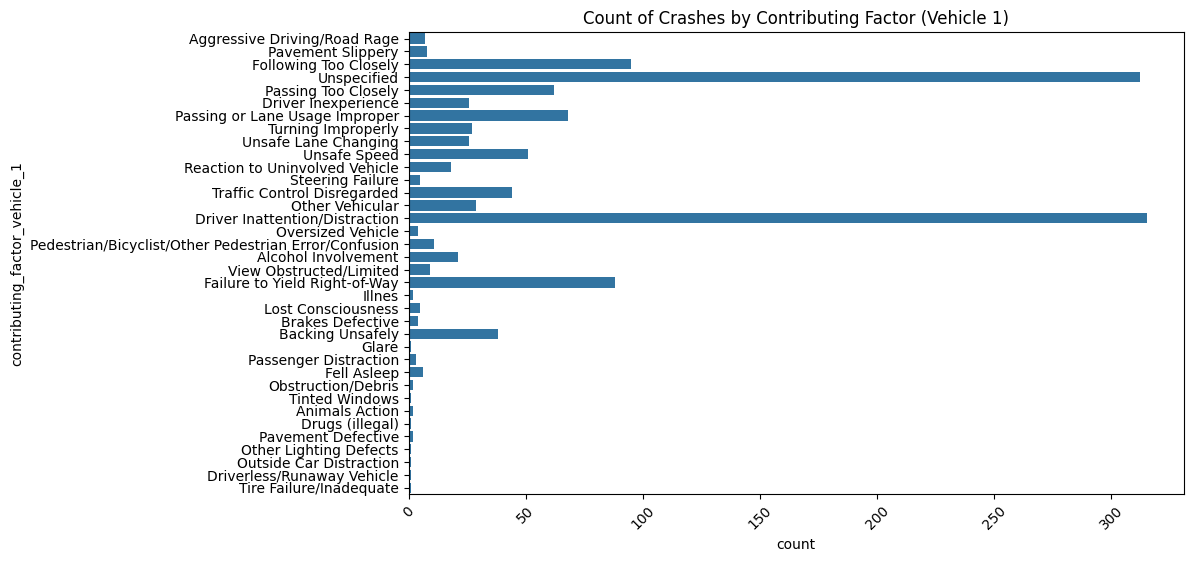

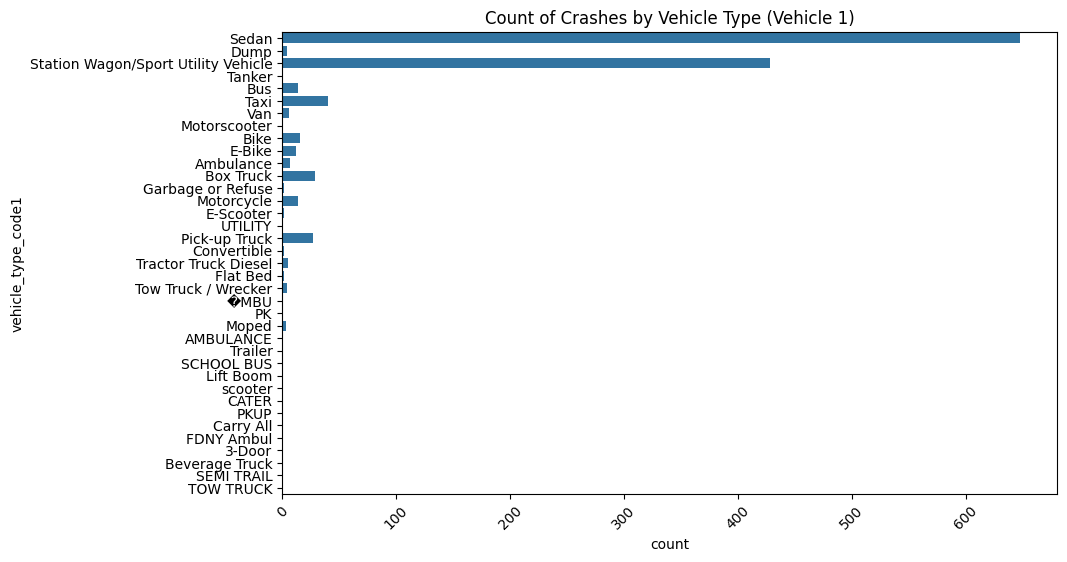

In [6]:
# Plot count plots for categorical variables
plt.figure(figsize=(10, 6))
sns.countplot(data['contributing_factor_vehicle_1'])
plt.title('Count of Crashes by Contributing Factor (Vehicle 1)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data['vehicle_type_code1'])
plt.title('Count of Crashes by Vehicle Type (Vehicle 1)')
plt.xticks(rotation=45)
plt.show()

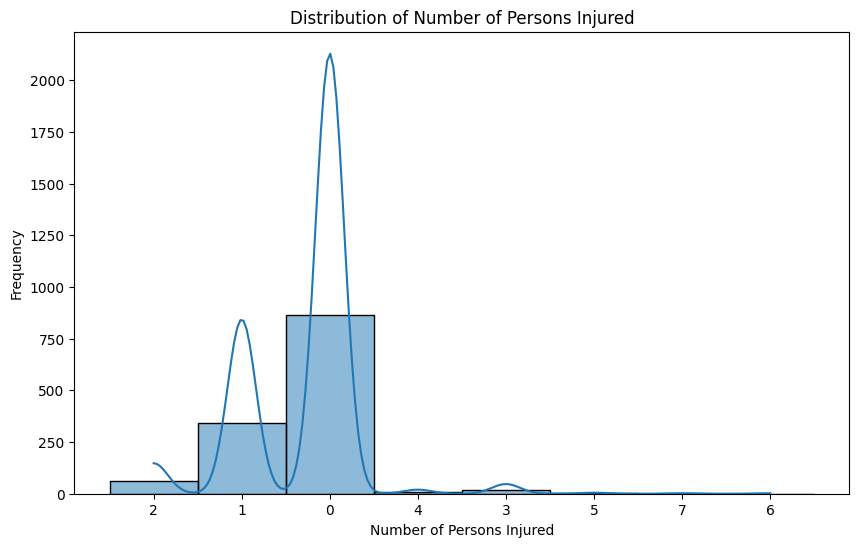

In [7]:
# histogram for numerical variables
plt.figure(figsize=(10, 6))
sns.histplot(data['number_of_persons_injured'], bins=20, kde=True)
plt.title('Distribution of Number of Persons Injured')
plt.xlabel('Number of Persons Injured')
plt.ylabel('Frequency')
plt.show()


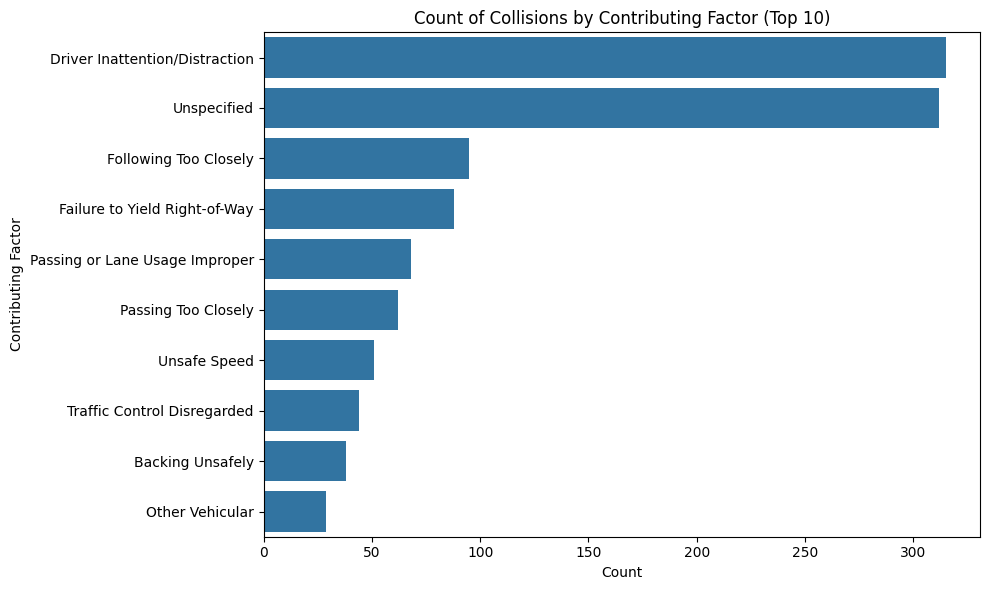

In [8]:
# Bar plot showing count of collisions by contributing factor
plt.figure(figsize=(10, 6))
sns.countplot(data=data, y='contributing_factor_vehicle_1', order=data['contributing_factor_vehicle_1'].value_counts().index[:10])
plt.title('Count of Collisions by Contributing Factor (Top 10)')
plt.xlabel('Count')
plt.ylabel('Contributing Factor')
plt.tight_layout()
plt.show()

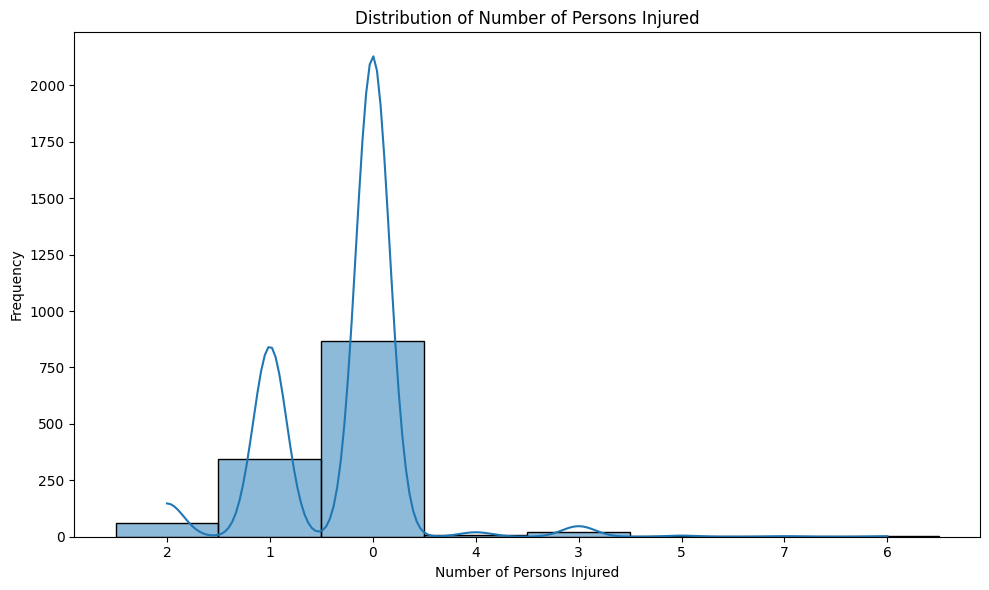

In [9]:
# Distribution of number of persons injured
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='number_of_persons_injured', bins=20, kde=True)
plt.title('Distribution of Number of Persons Injured')
plt.xlabel('Number of Persons Injured')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

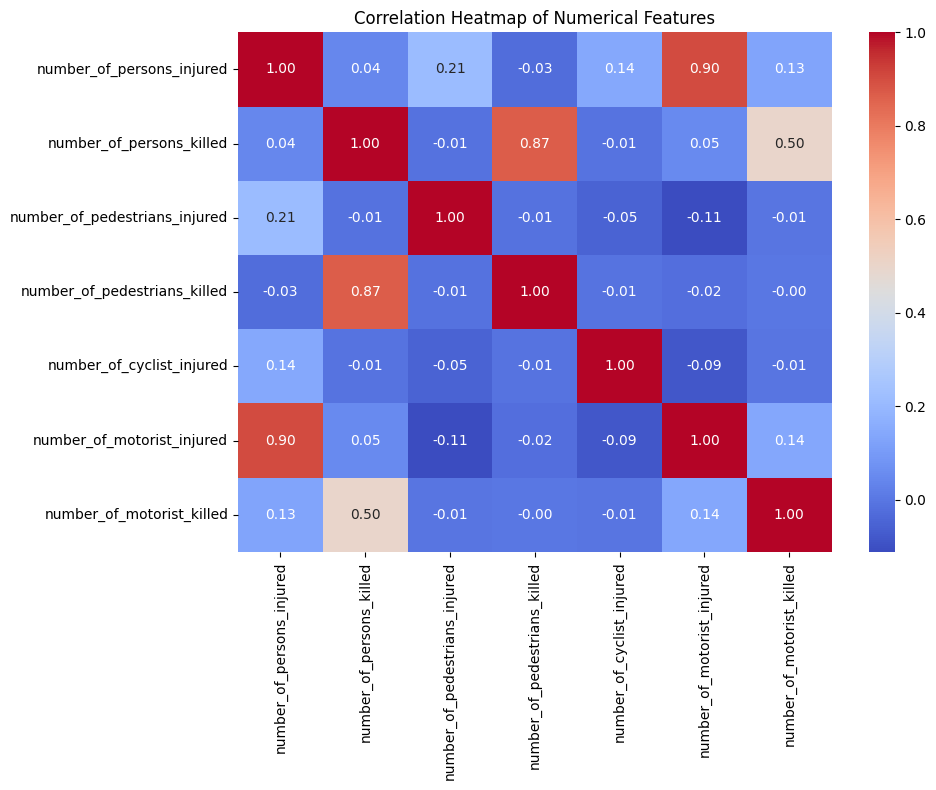

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

num_features = ['number_of_persons_injured', 'number_of_persons_killed', 'number_of_pedestrians_injured',
                'number_of_pedestrians_killed', 'number_of_cyclist_injured',
                'number_of_motorist_injured', 'number_of_motorist_killed']
# Correlation heatmap of numerical features
plt.figure(figsize=(10, 8))
corr = data[num_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()